# Logic Gate Task

This task utilizes a simple neural network containing single n-task context layer to learn eight different logic gates.

In [1]:
# Import Tensorflow and Keras layers
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

import math
import numpy as np
import random

# Import n-task library
from ntask.atr   import AtrMovingAverage
from ntask.layer import Context
from ntask.model import NTaskModel

## Dataset

In [2]:
gate_labels = ["xor", "xnor", "and", "or", "nor", "nand", "custom_1", "custom_2"]

In [3]:
gates = []
for label in gate_labels:
    with open(f"datasets/logic_gates/{label}.csv") as f:
        gate = []
        for line in f:
            row = list(map(int, line.split(',')))
            gate.append([np.array([row[:2]]), row[2]])
        gates.append(gate)

## Training and Validation

Some functions to conveniently train the model by shuffling the datasets and test the results.

In [4]:
def train(model, dataset, cycles, epochs, shuffle=True, show_progress=False):
    last_index = None
    indices = list(range(len(dataset)))
    
    for cycle in range(cycles):
        
        # If the previous task is repeated, swap with a random task
        if last_index == indices[0]:
            i = randrange(1, len(indices))
            indices[0], indices[i] = indices[i], indices[0]
        
        # Train on each batch in the dataset
        for i in indices:
            print(i)
            model.fit(dataset[i], epochs, progress=show_progress)
        
        # Shuffle at the end to preserver dataset order
        if shuffle:
            list_index = indices[-1]

            # Shuffle the dataset
            random.shuffle(indices)

In [5]:
def validate(model, dataset, num_task_contexts):
    labels = np.array([[[item[-1]] for item in batch] for batch in dataset])
    num_passed = 0
    for i in range(num_task_contexts):
        model.layers[model.context_layers[0]].set_hot_context(i)
        result = model(np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]]))
        predicted = np.round(model(np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]]))).astype(int)
        try:
            print(f"Task {i}:", end=' ')
            assert (predicted == labels[i]).all(), "Failed on task:"
            print(result, "Passed")
            num_passed += 1
        except AssertionError:
            print(result, "Failed")
    #     print(model(np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])))
    print(f"{num_passed}/{num_task_contexts} ({100*num_passed//num_task_contexts}%) Learned successfully")

### Loss Function

In [6]:
def loss_fn(labels, predictions):
    return tf.keras.losses.binary_crossentropy(y_true=labels, y_pred=predictions)

### Optimizer

In [7]:
optimizer = tf.keras.optimizers.Adam(1e-4)

___

## Static n-task - 2 Gates (XOR, XNOR) [PASSING]

In [8]:
dataset = gates[:2]
num_task_contexts = len(dataset)

In [9]:
random.seed(5)
tf.random.set_seed(5)

### Model

In [10]:
inp = Input((2,))
x = Dense(40, activation="relu")(inp)
x = Context(AtrMovingAverage(num_task_contexts, task_switch_threshold=-0.02))(x)
x = Dense(1, activation="sigmoid")(x)

In [11]:
model = NTaskModel(inputs=inp, outputs=x, loss_fn=loss_fn, optimizer=optimizer)

### Training

In [12]:
train(model, dataset, 3, 500)

0
1
Task switched to: 1
0
Task switched to: 0
1
Task switched to: 1
0
Task switched to: 0
1
Task switched to: 1


### Model Validation

Assert that the model has learned all logic gates

In [13]:
validate(model, dataset, num_task_contexts)

Task 0: tf.Tensor(
[[0.02289286]
 [0.9646863 ]
 [0.924756  ]
 [0.06937394]], shape=(4, 1), dtype=float32) Passed
Task 1: tf.Tensor(
[[0.9646759 ]
 [0.02893636]
 [0.05083215]
 [0.96020806]], shape=(4, 1), dtype=float32) Passed
2/2 (100%) Learned successfully


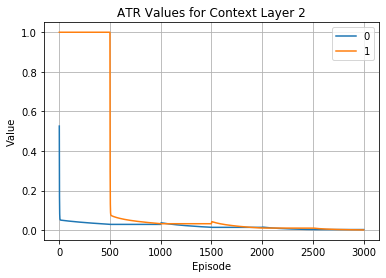

In [14]:
model.plot_atr_values()

___

## Dynamic n-task - 2 Gates (XOR, XNOR) [PASSING]

In [13]:
dataset = all_data[:2]
num_task_contexts = len(dataset)

In [44]:
random.seed(5)
tf.random.set_seed(5)

### Model

In [14]:
inp = Input((2,))
x = Dense(40, activation="relu")(inp)
x = Context(AtrMovingAverage(task_switch_threshold=-0.02, is_dynamic=True, task_add_threshold=0.1, max_num_tasks=num_task_contexts))(x)
x = Dense(1, activation="sigmoid")(x)

In [15]:
model = NTaskModel(inputs=inp, outputs=x, loss_fn=loss_fn, optimizer=optimizer)

### Training

In [16]:
train(model, dataset, 3, 500)

[1]
Progress: [###################-] 99.80%


### Model Validation

Assert that the model has learned all logic gates

In [19]:
validate(model, dataset, 2)

Task 0: tf.Tensor(
[[0.02289286]
 [0.9646863 ]
 [0.924756  ]
 [0.06937394]], shape=(4, 1), dtype=float32) Passed
Task 1: tf.Tensor(
[[0.9646759 ]
 [0.02893636]
 [0.05083215]
 [0.96020806]], shape=(4, 1), dtype=float32) Passed
2/2 (100%) Learned successfully


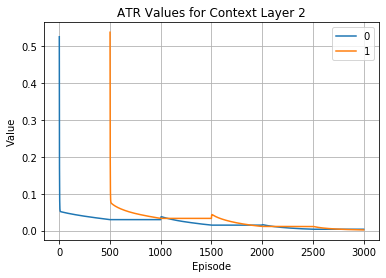

In [20]:
model.plot_atr_values()

## Static n-task - 8 Gates (XOR, XNOR, AND, OR) [PASSING]

In [43]:
dataset = all_data
num_task_contexts = len(dataset)

In [44]:
random.seed(5)
tf.random.set_seed(5)

### Model

In [50]:
inp = Input((2,))
x = Dense(128, activation="relu")(inp)
x = Context(AtrMovingAverage(num_task_contexts, task_switch_threshold=-0.02))(x)
x = Dense(1, activation="sigmoid")(x)

In [51]:
model = NTaskModel(inputs=inp, outputs=x, loss_fn=loss_fn, optimizer=optimizer)

### Training

In [52]:
train(model, dataset, 3, 500, shuffle=True, show_progress=False)

0
1
Task switched to: 1
2
Task switched to: 2
3
Task switched to: 3
4
Task switched to: 4
5
Task switched to: 5
6
Task switched to: 6
7
Task switched to: 7
7
4
Task switched to: 0
Task switched to: 1
Task switched to: 2
Task switched to: 3
Task switched to: 4
5
Task switched to: 5
0
Task switched to: 6
Task switched to: 7
Task switched to: 0
Task switched to: 1
Task switched to: 2
Task switched to: 3
Task switched to: 4
[<tf.Tensor: shape=(), dtype=float64, numpy=0.00215929949784624>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0025387555070497114>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0017970009890126565>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0008597773035224991>, <tf.Tensor: shape=(), dtype=float64, numpy=1.6522560546965008e-05>, <tf.Tensor: shape=(), dtype=float64, numpy=1.3964268734377342e-05>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0005211978327865172>, <tf.Tensor: shape=(), dtype=float64, numpy=1.743339491982597e-05>]
[<tf.Tensor: shape=(), dtype=float64, n

### Model Validation

Assert that the model has learned all logic gates

In [53]:
validate(model, dataset, num_task_contexts)

Task 0: tf.Tensor(
[[1.1052489e-03]
 [9.9884385e-01]
 [9.9699807e-01]
 [6.7400932e-04]], shape=(4, 1), dtype=float32) Passed
Task 1: tf.Tensor(
[[0.99985176]
 [0.01395854]
 [0.00874302]
 [0.9998234 ]], shape=(4, 1), dtype=float32) Passed
Task 2: tf.Tensor(
[[5.9211482e-07]
 [1.8263161e-03]
 [1.3484955e-03]
 [9.9993372e-01]], shape=(4, 1), dtype=float32) Passed
Task 3: tf.Tensor(
[[3.5664439e-04]
 [9.9996805e-01]
 [9.9985695e-01]
 [9.9992663e-01]], shape=(4, 1), dtype=float32) Passed
Task 4: tf.Tensor(
[[9.9972725e-01]
 [9.9988413e-01]
 [9.9984342e-01]
 [9.1708629e-05]], shape=(4, 1), dtype=float32) Passed
Task 5: tf.Tensor(
[[9.99703526e-01]
 [3.97711992e-04]
 [2.22742558e-04]
 [1.08098384e-07]], shape=(4, 1), dtype=float32) Passed
Task 6: tf.Tensor(
[[9.9988002e-01]
 [2.3394823e-04]
 [9.9998319e-01]
 [4.8339774e-05]], shape=(4, 1), dtype=float32) Passed
Task 7: tf.Tensor(
[[2.3092107e-05]
 [9.9998677e-01]
 [4.1616760e-05]
 [9.9867737e-01]], shape=(4, 1), dtype=float32) Passed
8/8 (100

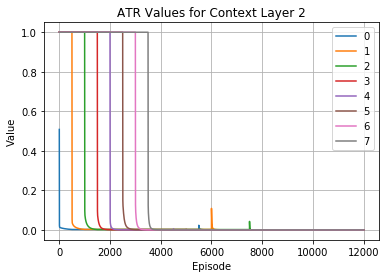

In [54]:
model.plot_atr_values()

## Dynamic n-task - 8 Gates

In [96]:
dataset = all_data
num_task_contexts = len(dataset)

In [97]:
random.seed(5)
tf.random.set_seed(5)

### Model

In [98]:
inp = Input((2,))
x = Dense(256, activation="relu")(inp)
x = Context(AtrMovingAverage(is_dynamic=True, task_switch_threshold=-0.02, task_add_threshold=0.025, max_num_tasks=num_task_contexts+1))(x)
x = Dense(1, activation="sigmoid")(x)

In [99]:
model = NTaskModel(inputs=inp, outputs=x, loss_fn=loss_fn, optimizer=optimizer)

### Training

In [100]:
train(model, dataset, 3, 750, shuffle=True, show_progress=False)

0
1
[<tf.Tensor: shape=(), dtype=float64, numpy=7.86181436044111e-05>]
[<tf.Tensor: shape=(), dtype=float64, numpy=0.12803729399554487>]
Best context loss... tf.Tensor(0.12803729399554487, shape=(), dtype=float64)
Task switched (added new task): 1
[<tf.Tensor: shape=(), dtype=float64, numpy=0.12803729399554487>, 0.0]
2
Task switched to: 0
[<tf.Tensor: shape=(), dtype=float64, numpy=7.86181436044111e-05>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0001017287925900474>]
[<tf.Tensor: shape=(), dtype=float64, numpy=0.13979306232325495>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0470387192921962>]
Best context loss... tf.Tensor(0.0470387192921962, shape=(), dtype=float64)
Task switched (added new task): 2
[<tf.Tensor: shape=(), dtype=float64, numpy=0.13979306232325495>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0470387192921962>, 0.0]
3
Task switched to: 0
Task switched to: 1
[<tf.Tensor: shape=(), dtype=float64, numpy=7.86181436044111e-05>, <tf.Tensor: shape=(), dtype=float64, nump

### Model Validation

Assert that the model has learned all logic gates

In [101]:
validate(model, dataset, num_task_contexts)

Task 0: tf.Tensor(
[[1.0742765e-06]
 [1.0000000e+00]
 [9.9999970e-01]
 [2.3760213e-05]], shape=(4, 1), dtype=float32) Passed
Task 1: tf.Tensor(
[[9.9999946e-01]
 [3.2362011e-06]
 [9.2593109e-06]
 [9.9999928e-01]], shape=(4, 1), dtype=float32) Passed
Task 2: tf.Tensor(
[[3.5098276e-07]
 [3.6427564e-06]
 [8.7419897e-07]
 [1.0000000e+00]], shape=(4, 1), dtype=float32) Passed
Task 3: tf.Tensor(
[[2.0309409e-07]
 [9.9999917e-01]
 [9.9999917e-01]
 [1.0000000e+00]], shape=(4, 1), dtype=float32) Passed
Task 4: tf.Tensor(
[[1.0000000e+00]
 [9.9999905e-01]
 [9.9999923e-01]
 [1.6106512e-06]], shape=(4, 1), dtype=float32) Passed
Task 5: tf.Tensor(
[[1.0000000e+00]
 [9.2727341e-06]
 [6.1473627e-05]
 [1.7354148e-06]], shape=(4, 1), dtype=float32) Passed
Task 6: tf.Tensor(
[[1.0000000e+00]
 [2.1363164e-07]
 [9.9999964e-01]
 [1.2838561e-06]], shape=(4, 1), dtype=float32) Passed
Task 7: tf.Tensor(
[[6.2210274e-06]
 [9.9999940e-01]
 [1.0556947e-06]
 [9.9999785e-01]], shape=(4, 1), dtype=float32) Passed


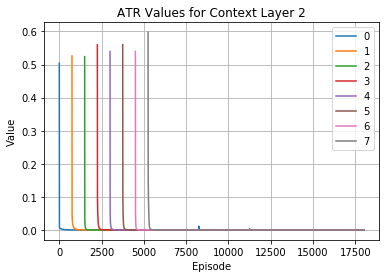

In [102]:
model.plot_atr_values()